# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

The love that the city of Hyderabad and its people show towards food and drinks is very well known. It is one the major foodie spots in India and people travel from all over the country to visit some of the famous restaurants which have developed a name for themselves through their quality of service offered and have become brands synonymous with certain foods. The act of opening a restaurant in such a booming region is an interesting opportunity for investors, chefs, and general food lovers in the city. To succeed in such a venture apart from quality in services offered good marketing, catering to the public demand, availability and “brand recognition” and other factors play an important role in deciding how successful and well known the restaurant is and how much attention it attracts. The location of a restaurant plays a major role in the success or failure it. A well-placed restaurant with regards to public demand and selecting the right neighbourhood are very important which is the main aim of this project. 

## Data <a name="data"></a>

To tackle this problem, we use the following data to complete the analysis:
- List of neighbourhoods in the city of Hyderabad: obtained from the Wikipedia page. 
- Geospatial data (latitude and longitude coordinates) of the neighbourhoods and venues in the project.
- Location data (venues, type of venue etc) from the Foursquare API which helps in the process of clustering the neighbourhoods.


## Methodology <a name="methodology"></a>

In this project we first obtain the neighborhood data of Hyderabad by scraping the corresponding Wikipedia page using the requests and BeautifulSoup packages of Python and create a data frame of the obtained data.<br>Then, using the geocoder package we obtain the geospatial data of the neighborhoods and for the city of Hyderabad(using the Nominatim package of geopy.geocoders)<br>After plotting the different neighborhoods using the folium package, we use the Foursquare API to get the location data of different venues and complete the exploratory analysis.<br>After we have the final dataset ready, we cluster the neighborhoods in k clusters(value of k decided using the elbow plot method) using the K-Means Clustering algorithm.<br> Based on the results of the clustering and some further analysis, we come to conclusion as to which neighborood in the city is the optimum location to open a new restaurant and also decide on the type of restaurant along the way.

## Analysis <a name="analysis"></a>

IMPORTING THE NECESSARY PACKAGES

In [1]:
import numpy as np #numpy for data as vectors
import pandas as pd #pandas for dataframe creation and manipulation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if needed
from geopy.geocoders import Nominatim

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if needed
import folium # map rendering library

!pip install beautifulsoup4
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         235 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2021.4.13-~ --> conda-forge::ca-certificates-

USING THE REQUESTS PACKAGE TO SCRAPE WIKIPEDIA TO GET THE NEIGHBORHOOD DATA

In [2]:
hyd_data = requests.get("https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Hyderabad,_India").text

Using BeautifulSoup to parse the html data and Pandas to create a Dataframe for the neighborhood information

In [3]:
soup = BeautifulSoup(hyd_data,'html.parser')


In [4]:
neighborhoods = []

In [5]:
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
  neighborhoods.append(row.text)

In [6]:
df = pd.DataFrame({"Neighborhood":neighborhoods})

In [7]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Hyderabad, India'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [8]:
coords = [ get_latlng(neighborhood) for neighborhood in df["Neighborhood"].tolist() ]

In [9]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [10]:
# merge the coordinates into the original dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

Getting the geospatial information of our target city of Hyderabad

In [11]:
# get the coordinates of Hyderabad
address = 'Hyderabad, India'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hyderabad, India {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hyderabad, India 17.360589, 78.4740613.


In [12]:
# create map of Hyderabad using latitude and longitude values
map_hyd = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_hyd)  
    
map_hyd

Using the Foursquare API to get the location data

In [13]:
CLIENT_ID = 'TRKFD4SGR0VN11RMFGCIB0CTWMF0KRG2OA0MRSNLSV20VO0S' # your Foursquare ID
CLIENT_SECRET = 'IZOPODB10GT0XXWKN00Y4LMUBCAN1VG4RFAUOVW2DBAYBNEG' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TRKFD4SGR0VN11RMFGCIB0CTWMF0KRG2OA0MRSNLSV20VO0S
CLIENT_SECRET:IZOPODB10GT0XXWKN00Y4LMUBCAN1VG4RFAUOVW2DBAYBNEG


In [14]:
radius = 2000
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [15]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head(10)

(6245, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,A. C. Guards,17.395015,78.459812,Subhan Bakery,17.392412,78.464712,Bakery
1,A. C. Guards,17.395015,78.459812,Cafe Niloufer & Bakers,17.399715,78.462881,Café
2,A. C. Guards,17.395015,78.459812,Chicha's,17.403255,78.460152,Hyderabadi Restaurant
3,A. C. Guards,17.395015,78.459812,Nizam club,17.403221,78.468729,Lounge
4,A. C. Guards,17.395015,78.459812,Taiba Bakers & Confectioners,17.402530,78.456823,Bakery
5,A. C. Guards,17.395015,78.459812,Siraj's International Juice Center,17.395579,78.442701,Juice Bar
6,A. C. Guards,17.395015,78.459812,Laxman Ki Bandi,17.378895,78.463973,South Indian Restaurant
7,A. C. Guards,17.395015,78.459812,Birla Science Museum,17.403854,78.469457,Science Museum
8,A. C. Guards,17.395015,78.459812,Baskin Robbins Red Hills,17.401600,78.463727,Ice Cream Shop
9,A. C. Guards,17.395015,78.459812,Rayalaseema Ruchulu,17.403084,78.463012,South Indian Restaurant


In [16]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 173 uniques categories.


In [17]:
venues_df['VenueCategory'].unique()[:50] #displays all the 174 category names

array(['Bakery', 'Café', 'Hyderabadi Restaurant', 'Lounge', 'Juice Bar',
       'South Indian Restaurant', 'Science Museum', 'Ice Cream Shop',
       'Stadium', 'Hotel', 'Bistro', 'Indian Restaurant', 'Park', 'Diner',
       'Middle Eastern Restaurant', 'Snack Place',
       'Vegetarian / Vegan Restaurant', 'Shoe Store', 'Neighborhood',
       'Dessert Shop', 'Performing Arts Venue', 'Hotel Bar',
       'Mobile Phone Shop', 'Chinese Restaurant', 'Fast Food Restaurant',
       'Pizza Place', 'Coffee Shop', 'Department Store', 'Shopping Mall',
       'Fried Chicken Joint', 'Clothing Store', 'Electronics Store',
       'Hookah Bar', 'Bookstore', 'Movie Theater', 'Convenience Store',
       'Sandwich Place', 'Asian Restaurant', 'Food Court',
       'Breakfast Spot', 'Light Rail Station', 'Restaurant', 'Food Truck',
       'Chaat Place', 'Burger Joint', 'Smoke Shop', 'Bar', 'Food',
       'Multiplex', 'Gaming Cafe'], dtype=object)

In [18]:
# one hot encoding
onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

print(onehot.shape)
onehot.head(20)

(6245, 174)


,Neighborhoods,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,BBQ Joint,Badminton Court,Bakery,Bank,Bar,Baseball Field,Bed & Breakfast,Beer Garden,Bengali Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Business Service,Cafeteria,Café,Candy Store,Caribbean Restaurant,Castle,Chaat Place,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hookah Bar,Hotel,Hotel Bar,Hotel Pool,Hunan Restaurant,Hyderabadi Restaurant,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Intersection,Irani Cafe,Irish Pub,Italian Restaurant,Jewelry Store,Juice Bar,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Museum,Neighborhood,New American Restaurant,Night Market,Nightclub,North Indian Restaurant,Office,Optical Shop,Outdoors & Recreation,Park,Parsi Restaurant,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Plaza,Pool,Pub,Punjabi Restaurant,Rajasthani Restaurant,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Social Club,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Tea Room,Tech Startup,Temple,Thai Restaurant,Train Station,Vegetarian / Vegan Restaurant,Wings Joint,Women's Store,Zoo
0,A. C. Guards,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,A. C. Guards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,A. C. Guards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,A. C. Guards,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,A. C. Guards,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [19]:
grouped = onehot.groupby('Neighborhoods').sum().reset_index()
grouped.head(10)

,Neighborhoods,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,BBQ Joint,Badminton Court,Bakery,Bank,Bar,Baseball Field,Bed & Breakfast,Beer Garden,Bengali Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Business Service,Cafeteria,Café,Candy Store,Caribbean Restaurant,Castle,Chaat Place,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hookah Bar,Hotel,Hotel Bar,Hotel Pool,Hunan Restaurant,Hyderabadi Restaurant,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Intersection,Irani Cafe,Irish Pub,Italian Restaurant,Jewelry Store,Juice Bar,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Museum,Neighborhood,New American Restaurant,Night Market,Nightclub,North Indian Restaurant,Office,Optical Shop,Outdoors & Recreation,Park,Parsi Restaurant,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Plaza,Pool,Pub,Punjabi Restaurant,Rajasthani Restaurant,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Social Club,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Tea Room,Tech Startup,Temple,Thai Restaurant,Train Station,Vegetarian / Vegan Restaurant,Wings Joint,Women's Store,Zoo
0,A. C. Guards,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,4,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,2,1,1,0,0,1,0,0,0,0,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,2,0,0,2,3,15,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,A. S. Rao Nagar,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,Abhyudaya Nagar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Abids,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,1,0,2,0,0,1,1,0,0,2,0,0,0,1,0,4,1,0,2,0,0,0,0,0,0,0,1,3,1,0,0,0,0,0,0,1,4,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1,0,0,0,5,12,0,1,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,1,1,1,2,0,0,2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
4,Adikmet,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0

In [20]:
grouped.shape

(198, 174)

Checking the top 3 most popular types of venues in each neighborhood

In [21]:
num_top_venues = 3

for hood in grouped['Neighborhoods']:
    print("----"+hood+"----")
    temp = grouped[grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----A. C. Guards----
                  venue  freq
0     Indian Restaurant  15.0
1                 Hotel   7.0
2  Fast Food Restaurant   5.0


----A. S. Rao Nagar----
               venue  freq
0  Indian Restaurant   7.0
1      Movie Theater   3.0
2  Convenience Store   2.0


----Abhyudaya Nagar----
            venue  freq
0   Movie Theater   3.0
1     Pizza Place   1.0
2  Ice Cream Shop   1.0


----Abids----
                  venue  freq
0     Indian Restaurant  12.0
1        Ice Cream Shop   5.0
2  Fast Food Restaurant   4.0


----Adikmet----
               venue  freq
0  Indian Restaurant   7.0
1  Convenience Store   2.0
2        Coffee Shop   2.0


----Afzal Gunj----
                     venue  freq
0        Indian Restaurant   5.0
1              Coffee Shop   3.0
2  South Indian Restaurant   3.0


----Aghapura----
               venue  freq
0  Indian Restaurant  13.0
1              Hotel   6.0
2             Bakery   4.0


----Aliabad, Hyderabad----
               venue  freq
0  In

In [22]:
#function to return the n most common venues in a neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
#getting the top venues and creating a dataframe for the same
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = grouped['Neighborhoods']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,A. C. Guards,Indian Restaurant,Hotel,Fast Food Restaurant,Café,Bakery
1,A. S. Rao Nagar,Indian Restaurant,Movie Theater,Convenience Store,Coffee Shop,Ice Cream Shop
2,Abhyudaya Nagar,Movie Theater,Coffee Shop,Fast Food Restaurant,Pizza Place,Ice Cream Shop
3,Abids,Indian Restaurant,Ice Cream Shop,Chinese Restaurant,Fast Food Restaurant,Dessert Shop
4,Adikmet,Indian Restaurant,Convenience Store,Coffee Shop,Bakery,Sandwich Place
5,Afzal Gunj,Indian Restaurant,South Indian Restaurant,Coffee Shop,Hotel,History Museum
6,Aghapura,Indian Restaurant,Hotel,Bakery,Café,Ice Cream Shop
7,"Aliabad, Hyderabad",Indian Restaurant,Breakfast Spot,History Museum,Train Station,Resort
8,Alijah Kotla,History Museum,Indian Restaurant,Coffee Shop,Dessert Shop,Diner
9,Allwyn Colony,Indian Restaurant,Fast Food Restaurant,Pizza Place,Hotel Bar,Middle Eastern Restaurant


Seeing which venue(food and non food related) is the most common/popular in the neighborhoods

In [24]:
neighborhoods_venues_sorted['1st Most Common Venue'].value_counts()

Indian Restaurant                95
ATM                              19
History Museum                   11
Fast Food Restaurant              9
Café                              7
Coffee Shop                       6
Movie Theater                     6
Train Station                     5
Gym                               4
South Indian Restaurant           3
Department Store                  3
Garden                            3
Pizza Place                       3
Park                              2
Convenience Store                 2
Middle Eastern Restaurant         2
Bakery                            2
Multiplex                         2
Ice Cream Shop                    1
Hookah Bar                        1
Zoo                               1
Vegetarian / Vegan Restaurant     1
Indie Movie Theater               1
Food Court                        1
Hotel                             1
Cricket Ground                    1
Breakfast Spot                    1
Historic Site               

Assumption: Since Indian Restaurants are the most common in the city, it is assumed they are also the most in demand type of restaurant. Hence for further analysis we pick Indian restaurants as the type of venue to cluster the neighborhoods on

In [25]:
#creating a dataframe only for Indian Restaurants
df_rest = grouped[["Neighborhoods","Indian Restaurant"]]
df_rest

,Neighborhoods,Indian Restaurant
0,A. C. Guards,15
1,A. S. Rao Nagar,7
2,Abhyudaya Nagar,0
3,Abids,12
4,Adikmet,7
5,Afzal Gunj,5
6,Aghapura,13
7,"Aliabad, Hyderabad",2
8,Alijah Kotla,2
9,Allwyn Colony,3


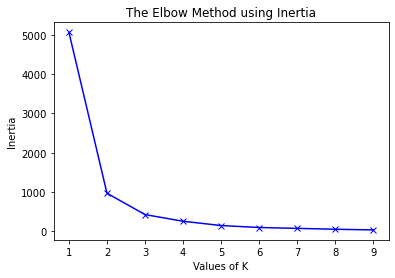

In [26]:
#Using the elbow method(inertia plot) of K-Means Clustering Algorithm to determine the optimum value of 'k' to be used
clustering = df_rest.drop(["Neighborhoods"], 1)
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(clustering)
    kmeanModel.fit(clustering)
 
    distortions.append(sum(np.min(cdist(clustering, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / clustering.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(clustering, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / clustering.shape[0]
    mapping2[k] = kmeanModel.inertia_
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Since the graph decreases linearly after the value of K=2 we proceed to choose the same for further clustering analysis and fitting the model

In [27]:
#fitting the model and generating the labels for the data
kclusters = 2
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0], dtype=int32)

In [28]:
#merging the cluster labels with the restaurant dataframe
df_merged = df_rest.copy()
df_merged['Cluster Label']=kmeans.labels_
df_merged['Latitude'] = df['Latitude']
df_merged['Longitude'] = df['Longitude']
df_merged.head()

,Neighborhoods,Indian Restaurant,Cluster Label,Latitude,Longitude
0,A. C. Guards,15,1,17.395015,78.459812
1,A. S. Rao Nagar,7,1,17.411200,78.508240
2,Abhyudaya Nagar,0,0,17.337650,78.564140
3,Abids,12,1,17.389800,78.476580
4,Adikmet,7,1,17.235790,78.541300


In [29]:
#create map for clustered data
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhoods'], df_merged['Cluster Label']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Taking a look at cluster 1, based on the prevoius assumption that increased frequency of a type of venue equates to its populairty/demand, we can see that Cluster 1 will be the ideal cluster to open an Indian restaurant

In [30]:
neighborhoods_venues_sorted['Cluster Label'] = df_merged['Cluster Label']
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Cluster Label']==1]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Label
0,A. C. Guards,Indian Restaurant,Hotel,Fast Food Restaurant,Café,Bakery,1
1,A. S. Rao Nagar,Indian Restaurant,Movie Theater,Convenience Store,Coffee Shop,Ice Cream Shop,1
3,Abids,Indian Restaurant,Ice Cream Shop,Chinese Restaurant,Fast Food Restaurant,Dessert Shop,1
4,Adikmet,Indian Restaurant,Convenience Store,Coffee Shop,Bakery,Sandwich Place,1
6,Aghapura,Indian Restaurant,Hotel,Bakery,Café,Ice Cream Shop,1
13,Ameerpet,Indian Restaurant,Coffee Shop,Hotel,Vegetarian / Vegan Restaurant,Pizza Place,1
15,"Ashok Nagar, Hyderabad",Indian Restaurant,Movie Theater,Restaurant,Ice Cream Shop,Chinese Restaurant,1
18,"Azamabad, Hyderabad",Indian Restaurant,Coffee Shop,Movie Theater,Fast Food Restaurant,Gym,1
21,Badichowdi,Indian Restaurant,Coffee Shop,Hotel,Ice Cream Shop,Fast Food Restaurant,1
22,Bagh Lingampally,Indian Restaurant,Movie Theater,Coffee Shop,Ice Cream Shop,Bakery,1


In K-means clustering, samples within a cluster have very similar properties. Based on this fact and to avoid heavy competition with other restaurants, we can pick a neighborhood in cluster 1 with the least number of Indian Restaurants to assure demand for the venue and avoid heavy competition at the same time

In [31]:
df_merged[(df_merged['Cluster Label']==1) & (df_merged['Indian Restaurant']==7)] # 7 is the min indian restaurant count in the cluster

,Neighborhoods,Indian Restaurant,Cluster Label,Latitude,Longitude
1,A. S. Rao Nagar,7,1,17.41120,78.50824
4,Adikmet,7,1,17.23579,78.54130
64,Golnaka,7,1,17.36507,78.52620
119,Maharajgunj,7,1,17.45694,78.39013
133,"Minister Road, Hyderabad",7,1,17.39263,78.44219
171,Putlibowli,7,1,17.42616,78.45210
178,"Ramnagar, Hyderabad",7,1,17.39032,78.54544
197,Shanker Mutt,7,1,17.35739,78.47320


These are the seven neighborhoods with the least number of Indian restaurants(7) in the cluster. To further narrow down our choice, we can take a look at the types of venues which are most common in the neighborhoods

In [66]:
select_neighborhoods = ['A. S. Rao Nagar','Adikmet','Golnaka','Maharajgunj','Minister Road, Hyderabad','Putlibowli','Ramnagar, Hyderabad','Shanker Mutt']
neighborhoods_venues_sorted[neighborhoods_venues_sorted.Neighborhoods.isin(select_neighborhoods)]

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster Label
1,A. S. Rao Nagar,Indian Restaurant,Movie Theater,Convenience Store,Coffee Shop,Ice Cream Shop,1
4,Adikmet,Indian Restaurant,Convenience Store,Coffee Shop,Bakery,Sandwich Place,1
64,Golnaka,Indian Restaurant,Coffee Shop,Movie Theater,Ice Cream Shop,Pizza Place,1
119,Maharajgunj,Indian Restaurant,Coffee Shop,South Indian Restaurant,Hotel,Diner,1
133,"Minister Road, Hyderabad",Indian Restaurant,Hotel,Bakery,Chinese Restaurant,Coffee Shop,1
171,Putlibowli,Indian Restaurant,Hotel,Diner,Pizza Place,Juice Bar,1
178,"Ramnagar, Hyderabad",Indian Restaurant,Movie Theater,Convenience Store,Coffee Shop,Ice Cream Shop,1
197,Shanker Mutt,Indian Restaurant,Movie Theater,Ice Cream Shop,Coffee Shop,Convenience Store,1


## Results and Discussion <a name="results"></a>

From the final table of seven neighbourhoods A.S Rao Nagar would be a good choice to start an Indian Restaurant as it has the joint least number of Indian restaurants in the cluster and it an urban area and also a major commercial and residential neighbourhood in the city of Hyderabad. This analysis can be further improved by selecting a target parameter based on which the suitability of a location can be decided based on the target parameter and further deciding the suitability of a neighbourhood in catering to a particular type of venue. The end location chosen in part of a cluster where similar such restaurants are of good popularity, but in a neighbourhood with not too many such venues, hence reducing the competition from other venues. The target audience of the selected location is also an added benefit which increases the amount of eyes/attention to the restaurant. The neighbourhood recommended at the end though can act as the starting point for further and deep analysis which could eventually result in location which has not only no nearby competition, but also other factors considered, and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

The main purpose of the project was to cluster neighborhoods in the city of Hyderabad in order to select an optimum location for the opening of a new restaurant. In the analysis we also looked at which type of restaurant (Indian) would be the most popular choice and the end decision was made considering the clustering results, demographical data and similarity of neighborhoods. To make a thorough decision additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc can also be considered